# Hackathon - Particle Images
*Yaqi Han*

*Mohammad Sayeb*

University of Florida



## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

# Download the Dataset

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2020-10-30 22:22:04--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 128.142.32.26, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  23.0MB/s    in 3.6s    

Last-modified header invalid -- time-stamp ignored.
2020-10-30 22:22:09 (23.0 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2020-10-30 22:22:09--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 128.142.32.26, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (

# Import modules

In [5]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [35]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 131072     # Training size
valid_size  = 4096     # Validation size
test_size   = 16384     # Test size
epochs      = 30       # Number of epochs
doGPU       = False    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [7]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Only the energy channel is taken into consideration.

In [8]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    X = X[:,:,:,0].reshape((X.shape[0],X.shape[1],X.shape[2],1))
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [36]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 150000, 150000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 180000, 180000+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


# Plot sample of training images


In [10]:

plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("photon example")  # photon
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[-1,:,:,0])
plt.title("electron example")  # electron
plt.grid(True)


plt.show()


'\nplt.figure(1)\n\nplt.subplot(221)\nplt.imshow(X_train[1,:,:,0])\nplt.title("Channel 0: Energy")  # Energy\nplt.grid(True)\n\nplt.subplot(222)\nplt.imshow(X_train[1,:,:,1])\nplt.title("Channel 1: Time")  # Time\nplt.grid(True)\n\n\nplt.show()\n'

# Define CNN Model

In [37]:
### Define Convolutional Neural Network (CNN) Model ###

model = Sequential()
#initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, 1)))
#model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, activation = 'relu', kernel_size=3, padding = 'same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Nadam(lr=lr_init), metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)             

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

In [38]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs+10,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/30
4096/4096 [==============================] - 19s 5ms/step - loss: 0.6026 - accuracy: 0.6798 - val_loss: 0.5810 - val_accuracy: 0.7042
Epoch 2/30
4096/4096 [==============================] - 18s 4ms/step - loss: 0.5727 - accuracy: 0.7117 - val_loss: 0.5683 - val_accuracy: 0.7123
Epoch 3/30
4096/4096 [==============================] - 19s 5ms/step - loss: 0.5649 - accuracy: 0.7168 - val_loss: 0.5605 - val_accuracy: 0.7164
Epoch 4/30
4096/4096 [==============================] - 18s 5ms/step - loss: 0.5611 - accuracy: 0.7195 - val_loss: 0.5568 - val_accuracy: 0.7201
Epoch 5/30
4096/4096 [==============================] - 18s 4ms/step - loss: 0.5586 - accuracy: 0.7215 - val_loss: 0.5548 - val_accuracy: 0.7186
Epoch 6/30
4096/4096 [==============================] - 18s 4ms/step - loss: 0.5563 - accuracy: 0.7224 - val_loss: 0.5535 - val_accuracy: 0.7156
Epoch 7/30
4096/4096 [==============================] - 18s 4ms/step - loss: 0.5544 - accuracy: 0.7247 - val_loss: 0.5628 - val_ac

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [39]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

256/256 [==============================] - 1s 2ms/step - loss: 0.5409 - accuracy: 0.7299

Validation loss / accuracy: 0.5409 / 0.7299
Validation ROC AUC: 0.8014571666717529
1024/1024 [==============================] - 2s 2ms/step - loss: 0.5350 - accuracy: 0.7384

Test loss / accuracy: 0.5350 / 0.7384
Test ROC AUC: 0.8072340562939644


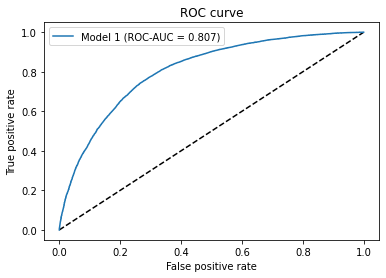

In [40]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [44]:
model.save('Model.h5')
model.save_weights('weights.h5')

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 